In [1]:
from utils import load_parquet_to_df_list


path = "../../../../0_data/synth_pattern_data_for_synth_drive_generation"
df_list = load_parquet_to_df_list(path)

# do not use metadata of time series
df_orig = [df["dim_0"].to_frame() for df in df_list]

In [2]:
df_orig[0]

,dim_0
0,70.902463
1,70.282942
2,68.703804
3,64.193219
4,60.321183
...,...
896,79.357289
897,88.933892
898,83.036114
899,85.052833


In [3]:
from utils import z_normalize


# additionally cut of some time series for a shorter representation
df_norm = [z_normalize(df) for df in df_orig[:3]]
num_dfs = len(df_norm)

### Discretization variants

In [4]:
from discretization.sax.sax import SAX
from discretization.sax.one_d_sax import OneDSAX
from discretization.sax.adaptive_sax import AdaptiveSAX
from discretization.sax.extended_sax import ExtendedSAX
from discretization.persist.persist import Persist


alphabet_size = 8
alphabet_size_slope = 8

sax = SAX(alphabet_size)
one_d_sax = OneDSAX(alphabet_size, alphabet_size_slope)
a_sax = AdaptiveSAX(alphabet_size)
e_sax = ExtendedSAX(alphabet_size)
persist = Persist(alphabet_size)

### Random Projection algorithm

### Params for Random Projection algorithm

In [5]:
sax_variant = sax
len_subsequence = 20
window_size = 5
num_projections = 40
mask_size = 2
# set radius very high ('inf') to evaluate only the impact of the respective symbolic representation
radius = 5
# reduce search space based on collisions of two symbolic representations
# should be lower for 1d-SAX and eSAX to account for more than one symbol per segment for better comparability with SAX and aSAX
# lower it for larger motifs, because both queries need a high number of collisions with subsequence under investigation
min_collisions = 8
ignore_trivial = True
exclusion_zone = None

### Find motifs

In [6]:
from pattern_recognition.motif_discovery.random_projection import do_random_projection


motifs_lst, start, end = do_random_projection(df_norm[0], len_subsequence, window_size, sax_variant, num_projections, mask_size, radius, min_collisions, ignore_trivial, exclusion_zone)

In [7]:
motifs_lst

[[[0,
   61,
   64,
   156,
   159,
   197,
   200,
   330,
   337,
   402,
   419,
   422,
   472,
   475,
   491,
   557,
   606,
   609,
   657,
   660,
   724,
   727,
   767,
   770,
   831,
   834],
  [3,
   15,
   67,
   162,
   173,
   203,
   405,
   408,
   425,
   478,
   562,
   612,
   663,
   671,
   730,
   773,
   837],
  [7, 20, 70, 73, 166, 178, 206, 429, 482, 676, 734, 841],
  [10, 334, 413, 432, 440, 485, 494, 565, 616, 666, 744, 777, 784, 787, 853],
  [23, 217, 443, 446, 497, 500, 679, 682, 748, 751],
  [26, 29, 222, 225, 299, 449, 503, 523, 685, 754],
  [32,
   35,
   86,
   186,
   257,
   281,
   304,
   354,
   377,
   509,
   528,
   544,
   578,
   634,
   710,
   758,
   794,
   818],
  [38,
   91,
   94,
   263,
   286,
   291,
   309,
   312,
   362,
   381,
   384,
   463,
   467,
   514,
   517,
   533,
   582,
   586,
   699,
   702,
   705,
   763,
   823,
   826,
   865],
  [41,
   44,
   97,
   100,
   123,
   129,
   244,
   250,
   254,
   315,
   

### Highlight motif within time series

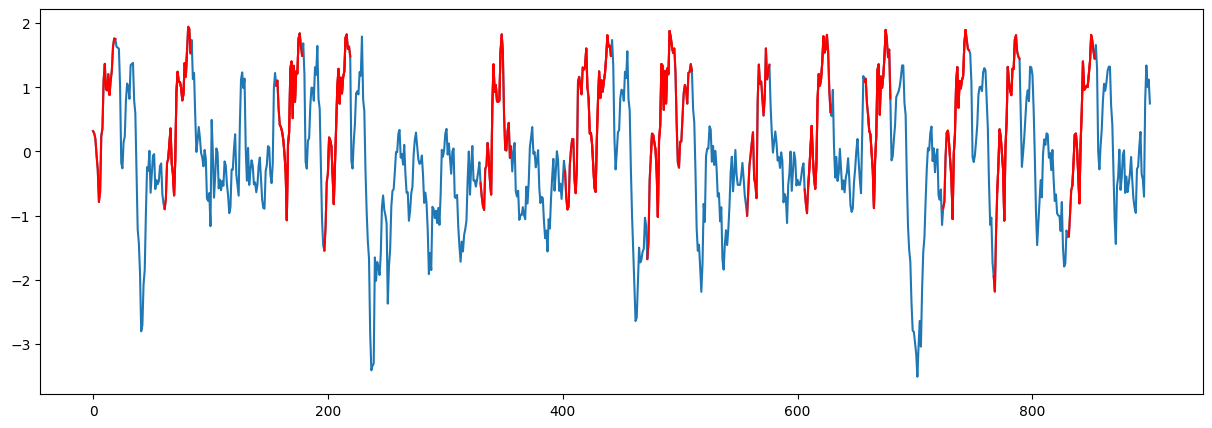

In [8]:
from pattern_recognition.motif_discovery.graphics import highlight_motif


highlight_motif(df_norm[0], start, end, motifs_lst[0][0], 0)

### Get motif per subsequence

In [9]:
from pattern_recognition.motif_discovery.utils import get_motifs_per_subsequence


motifs_subsequence_lst = get_motifs_per_subsequence(motifs_lst)

In [10]:
motifs_subsequence_lst

[{0: [61,
   64,
   156,
   159,
   197,
   200,
   330,
   337,
   402,
   419,
   422,
   472,
   475,
   491,
   557,
   606,
   609,
   657,
   660,
   724,
   727,
   767,
   770,
   831,
   834],
  3: [15,
   67,
   162,
   173,
   203,
   405,
   408,
   425,
   478,
   562,
   612,
   663,
   671,
   730,
   773,
   837],
  7: [20, 70, 73, 166, 178, 206, 429, 482, 676, 734, 841],
  10: [334, 413, 432, 440, 485, 494, 565, 616, 666, 744, 777, 784, 787, 853],
  15: [3,
   67,
   162,
   173,
   203,
   405,
   408,
   425,
   478,
   562,
   612,
   663,
   671,
   730,
   773,
   837],
  20: [7, 70, 73, 166, 178, 206, 429, 482, 676, 734, 841],
  23: [217, 443, 446, 497, 500, 679, 682, 748, 751],
  26: [29, 222, 225, 299, 449, 503, 523, 685, 754],
  29: [26, 222, 225, 299, 449, 503, 523, 685, 754],
  32: [35,
   86,
   186,
   257,
   281,
   304,
   354,
   377,
   509,
   528,
   544,
   578,
   634,
   710,
   758,
   794,
   818],
  35: [32,
   86,
   186,
   257,
   281,
   3

### Remove trivial motifs for each subsequnce
Given a subsequence 'S' with index 'a'. A trivial motif of 'S' is a motif of 'S' with index 'k' and all subsequences with indexes between 'a' and 'k' are motifs of 'S' as well. Intuitively, a motif that is near 'S' is not a trivial motif of 'S' if and only if there is at least one subsequence between them that is not a motif of 'S'.

In [11]:
from pattern_recognition.motif_discovery.utils import remove_trivial_motifs_per_subsequence


removed = remove_trivial_motifs_per_subsequence(motifs_subsequence_lst)

In [12]:
removed

[{0: [61,
   64,
   156,
   159,
   197,
   200,
   330,
   337,
   402,
   419,
   422,
   472,
   475,
   491,
   557,
   606,
   609,
   657,
   660,
   724,
   727,
   767,
   770,
   831,
   834],
  3: [15,
   67,
   162,
   173,
   203,
   405,
   408,
   425,
   478,
   562,
   612,
   663,
   671,
   730,
   773,
   837],
  7: [20, 70, 73, 166, 178, 206, 429, 482, 676, 734, 841],
  10: [334, 413, 432, 440, 485, 494, 565, 616, 666, 744, 777, 784, 787, 853],
  15: [3,
   67,
   162,
   173,
   203,
   405,
   408,
   425,
   478,
   562,
   612,
   663,
   671,
   730,
   773,
   837],
  20: [7, 70, 73, 166, 178, 206, 429, 482, 676, 734, 841],
  23: [217, 443, 446, 497, 500, 679, 682, 748, 751],
  26: [29, 222, 225, 299, 449, 503, 523, 685, 754],
  29: [26, 222, 225, 299, 449, 503, 523, 685, 754],
  32: [35,
   86,
   186,
   257,
   281,
   304,
   354,
   377,
   509,
   528,
   544,
   578,
   634,
   710,
   758,
   794,
   818],
  35: [32,
   86,
   186,
   257,
   281,
   3

### Algorithm based on Matrix Profile

### Params for Matrix Profile Algorithm

In [13]:
# motif length in original time series = len_symbolic_subsequence * window_size
sax_variant = e_sax
# number of segments to be looked at, various symbols within segment, depends on SAX variant
num_compare_segments = 4
window_size = 5
# is higher for 1d-SAX and even higher for eSAX, because they contain more symbols per segment
max_distance = 5

In [14]:
from pattern_recognition.motif_discovery.matrix_profile.discretized import do_matrix_profile_discretized

# finds motifs directly on symbolic representations of time series --> very few points
# start and end are adjusted such that indexes for symbolic representations can simply be used
motifs_lst, start, end = do_matrix_profile_discretized(df_norm[0], window_size, sax_variant, num_compare_segments, max_distance)

In [15]:
motifs_lst

[[[32, 40, 132, 167],
  [35, 170],
  [44, 89, 100, 136, 150],
  [14, 33, 96, 155, 168],
  [54, 59, 104, 161],
  [4, 99, 149],
  [46, 91, 138],
  [2, 86, 97, 147],
  [10, 21, 127],
  [6, 101, 151],
  [110, 176],
  [22, 65, 128],
  [45, 90, 137],
  [3, 87, 98, 148],
  [64, 109, 175],
  [85, 146],
  [92, 139],
  [62, 107],
  [0, 95],
  [43, 88, 135, 149],
  [60, 105],
  [50, 103],
  [34, 156, 169],
  [39, 166],
  [63, 108, 174],
  [36, 171]]]

### Highlight motif within time series

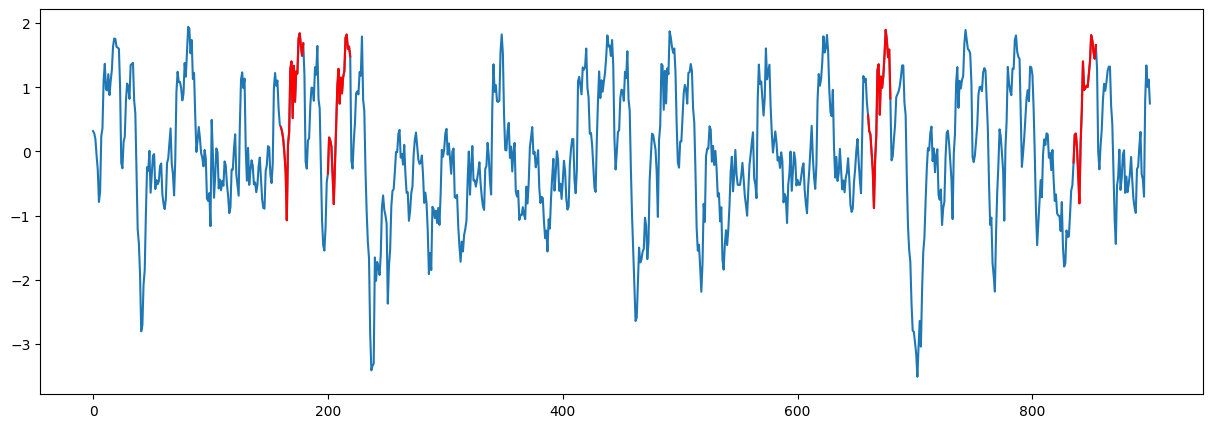

In [16]:
highlight_motif(df_norm[0], start, end, motifs_lst[0][0], 0)